In [1]:
import os
import numpy as np
import time
from IPython.utils import io
from collections import OrderedDict

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
# from torchsummary import summary
import gc

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib import patches as mpatches  # Import mpatches here
import matplotlib.ticker as ticker

# from TransAttUnet import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
data_path = '/kaggle/input/medical-aug2024'
# List the contents of the data directory
print(os.listdir(data_path))

# image_dir = '/kaggle/input/cs604-project/train_images/'
# mask_dir = '/kaggle/input/cs604-project/train_masks/'

image_dir = f'{data_path}/train_images/'
mask_dir = f'{data_path}/train_masks/'

all_filenames = sorted(os.listdir(image_dir))

# define class_names
class_names = ['background', 'spleen', 'right kidney', 'left kidney', 'gallbladder', 'pancreas', 'liver', 'stomach', 'aorta']
num_classes = len(class_names)

['train_images', 'train_masks']


# **Train Val Split into 90-10**

In [ ]:
total_images = len(all_filenames)

# Calculate the number of images for each set
train_size = int(0.90 * total_images)
val_size = int(0.10 * total_images)

# First split into training and temp (validation + test)
train_filenames, val_filenames = train_test_split(all_filenames,test_size=(val_size),random_state=42)

# Now split temp into validation and test
# val_filenames, test_filenames = train_test_split(temp_filenames,test_size=test_size,random_state=42)

print(f"Total images: {len(all_filenames)}")
print(f"Training images: {len(train_filenames)}")
print(f"Validation images: {len(val_filenames)}")
# print(f"Test images: {len(test_filenames)}")     


Total images: 1631
Training images: 1468
Validation images: 163


# Helper Functions

In [5]:
def check_and_clear_cuda_memory(device):
    """
    Check the allocated and reserved CUDA memory for the specified device,
    clear the CUDA cache, and collect garbage.

    Parameters:
    device (torch.device): The CUDA device to check memory for.
    """
    if torch.cuda.is_available():
        # Clear the CUDA cache
        torch.cuda.empty_cache()
        
        # Help clear up any remaining references
        gc.collect()

        # Check memory allocated and reserved
        allocated_memory = torch.cuda.memory_allocated(device)
        reserved_memory = torch.cuda.memory_reserved(device)

        print(f"Memory Allocated: {allocated_memory / (1024 ** 2):.2f} MB")
        print(f"Memory Reserved: {reserved_memory / (1024 ** 2):.2f} MB")

        print("Cleared CUDA cache and remaining references.")

    else:
        print("CUDA is not available on this device.")

def plot_ordered_dict(ordered_dict):
    # Extract` keys and values from the ordered dictionary
    keys = list(ordered_dict.keys())
    values = list(ordered_dict.values())
    
    # Create a bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(keys, values, color='blue')
    
    # Add title and labels
    plt.title('Bar Chart from Ordered Dictionary')
    plt.xlabel('Keys')
    plt.ylabel('Values')
    
    # Show the plot
    plt.show()

def calculate_weight_tensors(class_counts):
    # Calculate the total number of samples
    total_samples = sum(class_counts)
    
    # Calculate the inverse frequency for each class
    weights = [total_samples / count for count in class_counts]
    
    # Convert the list of weights to a tensor
    weight_tensors = torch.tensor(weights, dtype=torch.float32)
    
    return weight_tensors

def calculate_elapsed_time(start):
    # Convert elapsed time to hours, minutes, seconds, and milliseconds
    elapsed_time = time.time() - start
    hours, remainder = divmod(elapsed_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    milliseconds = (seconds - int(seconds)) * 1000

    # Print the results
    print ('\n')
    print("=" * 100)
    print(f"Total runtime: {int(hours)} hours, {int(minutes)} minutes, {int(seconds)} seconds, {int(milliseconds)} milliseconds")
    print("=" * 100, '\n')

def plot_learning_curves(train_losses, val_losses, train_miou, val_miou, learning_rates, save_path='lc_plots/lc_plot.png'):
    """
    Plots the training and validation learning curves for losses, mIoU, and learning rates on secondary axes.
    
    Parameters:
    - train_losses: List of training losses.
    - val_losses: List of validation losses.
    - train_miou: List of training mIoU values.
    - val_miou: List of validation mIoU values.
    - learning_rates: List of learning rates used during training.
    - save_path (str): The name of the file to save the plot (default: 'lc_plots/lc_plot.png').
    """
    if not os.path.exists(os.path.dirname(save_path)):
        os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Create directory if it doesn't exist
    
    # Create a figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))  # Side by side subplots
    
    # Plot training and validation losses
    ax1.plot(train_losses, label='Training Loss', color='blue', marker='o')
    ax1.plot(val_losses, label='Validation Loss', color='orange', marker='o')
    
    # Add labels and title for the first subplot
    ax1.set_title('Training and Validation Losses')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.grid()

    # Create a secondary y-axis for learning rates on the first subplot
    ax1_lr = ax1.twinx()
    
    # Plot learning rates on the secondary y-axis
    ax1_lr.plot(learning_rates, label='Learning Rate', color='purple', marker='x', alpha=0.5)
    
    # Add labels for the secondary axis
    ax1_lr.set_ylabel('Learning Rate')

    # Set scientific notation format for y-axis ticks
    ax1_lr.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.4e'))

    # Combine legends for the first subplot
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles_lr1, labels_lr1 = ax1_lr.get_legend_handles_labels()
    
    # Combine handles and labels for the first subplot
    handles_combined_1 = handles1 + handles_lr1
    labels_combined_1 = labels1 + labels_lr1
    
    # Create a single legend for the first subplot
    ax1.legend(handles_combined_1, labels_combined_1, loc='upper right')

    # Plot training and validation mIoU
    ax2.plot(train_miou, label='Training mIoU', color='blue', marker='o')
    ax2.plot(val_miou, label='Validation mIoU', color='orange', marker='o')
    
    # Add labels and title for the second subplot
    ax2.set_title('Training and Validation mIoU')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Mean IoU')
    ax2.grid()

    # Create a secondary y-axis for learning rates on the second subplot
    ax2_lr = ax2.twinx()
    
    # Plot learning rates on the secondary y-axis
    ax2_lr.plot(learning_rates, label='Learning Rate', color='purple', marker='x', alpha=0.5)
    
    # Add labels for the secondary axis
    ax2_lr.set_ylabel('Learning Rate')

    # Set scientific notation format for y-axis ticks on second subplot
    ax2_lr.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.4e'))

    # Combine legends for the second subplot
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles_lr2, labels_lr2 = ax2_lr.get_legend_handles_labels()
    
    # Combine handles and labels for the second subplot
    handles_combined_2 = handles2 + handles_lr2
    labels_combined_2 = labels2 + labels_lr2
    
    # Create a single legend for the second subplot
    ax2.legend(handles_combined_2, labels_combined_2, loc='lower right')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.savefig(save_path, format='png')
    print(f"Train and validation mIoU and loss plots saved as '{save_path}'")
    # Show the plot
    plt.show()


def compute_iou(preds, labels, num_classes):
    """
    Computes IoU for each class between predicted labels and ground truth labels.

    Args:
        preds (torch.Tensor): Predicted labels, shape (N, H, W)
        labels (torch.Tensor): Ground truth labels, shape (N, H, W)
        num_classes (int): Number of classes

    Returns:
        list: IoU for each class
    """
    ious = []
    preds = preds.view(-1)
    labels = labels.view(-1)
    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = labels == cls
        intersection = torch.sum((pred_inds & target_inds).float()).item()
        union = torch.sum((pred_inds | target_inds).float()).item()
        if union == 0:
            iou = float('nan')  # If there is no ground truth, set IoU to NaN
        else:
            iou = intersection / union
        ious.append(iou)
    return ious

# Dataset Loader

In [6]:
class ImageMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, filenames, transform_image=None, transform_mask=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = filenames
        self.transform_image = transform_image
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        image_path = os.path.join(self.image_dir, img_name)
        mask_name = img_name  # Filenames match
        mask_path = os.path.join(self.mask_dir, mask_name)

        # Load image and mask
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # Apply transformations
        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask

    def get_class_sample_count(self):
        """
        Returns the number of training samples per class based on the masks.
        
        Returns:
            dict: A dictionary where keys are class labels and values are counts of samples.
        """
        sample_counts = {}
        
        for img_name in self.image_filenames:
            mask_path = os.path.join(self.mask_dir, img_name)
            mask = Image.open(mask_path).convert("L")
            mask_array = np.array(mask)

            # Get unique classes in the mask
            unique_classes = np.unique(mask_array)

            # Count this image for each unique class present
            for cls in unique_classes:
                if cls not in sample_counts:
                    sample_counts[cls] = 1
                else:
                    sample_counts[cls] += 1

        # Sort the dictionary by keys and convert to OrderedDict
        sorted_sample_counts = OrderedDict(sorted(sample_counts.items()))
        
        return sorted_sample_counts
    
    def get_class_distribution(self):
        """
        Returns the number of training samples per class based on the masks.
        
        Returns:
            dict: A dictionary where keys are class labels and values are counts of samples.
        """
        class_counts = {}
        
        for img_name in self.image_filenames:
            mask_path = os.path.join(self.mask_dir, img_name)
            mask = Image.open(mask_path).convert("L")
            mask_array = np.array(mask)

            # Count unique classes in the mask
            unique_classes, counts = np.unique(mask_array, return_counts=True)

            for cls, count in zip(unique_classes, counts):
                if cls not in class_counts:
                    class_counts[cls] = count
                else:
                    class_counts[cls] += count
        
        return class_counts
    
    def plot_class_distribution(self):
        """
        Plots a bar chart of the class distribution.
        """
        class_distribution = self.get_class_distribution()

        # Prepare data for plotting, excluding class 0
        filtered_classes = {k: v for k, v in class_distribution.items() if k != 0}
        
        # Prepare data for plotting
        classes = list(filtered_classes.keys())
        counts = list(filtered_classes.values())

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.bar(classes, counts, color='skyblue')
        
        plt.xlabel('Class Labels')
        plt.ylabel('Pixel Count')
        plt.title('Class Distribution in Dataset')
        
        # Optionally set x-ticks to be more readable if there are many classes
        plt.xticks(classes)
        
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        plt.show()



In [7]:
train_transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
#     transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.Lambda(lambda img: img + torch.randn_like(img) * 0.05),  # Adding Gaussian noise
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


val_transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_mask = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.NEAREST),
    transforms.PILToTensor(),
    transforms.Lambda(lambda x: x.squeeze().long())
])

In [8]:
# Training dataset and loader
train_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=train_filenames,
    transform_image=train_transform_image,
    transform_mask=transform_mask
)


# Validation dataset and loader
val_dataset = ImageMaskDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    filenames=val_filenames,
    transform_image=val_transform_image,
    transform_mask=transform_mask
)


# Test dataset and loader
# test_dataset = ImageMaskDataset(
#     image_dir=image_dir,
#     mask_dir=mask_dir,
#     filenames=test_filenames,
#     transform_image=transform_image,
#     transform_mask=transform_mask
# )
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)


# Custom Loss Function

In [9]:
import typing
from typing import List
from typing import Optional
from torch import Tensor
from torch.nn.modules.loss import _Loss


def to_tensor(x, dtype=None) -> torch.Tensor:
    if isinstance(x, torch.Tensor):
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, np.ndarray) and x.dtype.kind not in {"O", "M", "U", "S"}:
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, (list, tuple)):
        x = np.ndarray(x)
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x

    raise ValueError("Unsupported input type" + str(type(x)))


def soft_dice_score(
    output: torch.Tensor, target: torch.Tensor, smooth: float = 0.0, eps: float = 1e-7, dims=None
) -> torch.Tensor:
    """

    :param output:
    :param target:
    :param smooth:
    :param eps:
    :return:

    Shape:
        - Input: :math:`(N, NC, *)` where :math:`*` means any number
            of additional dimensions
        - Target: :math:`(N, NC, *)`, same shape as the input
        - Output: scalar.

    """
    assert output.size() == target.size()
    if dims is not None:
        intersection = torch.sum(output * target, dim=dims)
        cardinality = torch.sum(output + target, dim=dims)
    else:
        intersection = torch.sum(output * target)
        cardinality = torch.sum(output + target)
    dice_score = (2.0 * intersection + smooth) / (cardinality + smooth).clamp_min(eps)
    return dice_score


__all__ = ["DiceLoss"]

BINARY_MODE = "binary"
MULTICLASS_MODE = "multiclass"
MULTILABEL_MODE = "multilabel"


class DiceLoss(_Loss):
    """
    Implementation of Dice loss for image segmentation task.
    It supports binary, multiclass and multilabel cases
    """

    def __init__(
        self,
        mode: str,
        classes: List[int] = None,
        log_loss=False,
        from_logits=True,
        smooth: float = 0.0,
        ignore_index=None,
        eps=1e-7,
    ):
        """

        :param mode: Metric mode {'binary', 'multiclass', 'multilabel'}
        :param classes: Optional list of classes that contribute in loss computation;
        By default, all channels are included.
        :param log_loss: If True, loss computed as `-log(jaccard)`; otherwise `1 - jaccard`
        :param from_logits: If True assumes input is raw logits
        :param smooth:
        :param ignore_index: Label that indicates ignored pixels (does not contribute to loss)
        :param eps: Small epsilon for numerical stability
        """
        assert mode in {BINARY_MODE, MULTILABEL_MODE, MULTICLASS_MODE}
        super(DiceLoss, self).__init__()
        self.mode = mode
        if classes is not None:
            assert mode != BINARY_MODE, "Masking classes is not supported with mode=binary"
            classes = to_tensor(classes, dtype=torch.long)

        self.classes = classes
        self.from_logits = from_logits
        self.smooth = smooth
        self.eps = eps
        self.ignore_index = ignore_index
        self.log_loss = log_loss

    def forward(self, y_pred: Tensor, y_true: Tensor) -> Tensor:
        """

        :param y_pred: NxCxHxW
        :param y_true: NxHxW
        :return: scalar
        """
        assert y_true.size(0) == y_pred.size(0)

        if self.from_logits:
            # Apply activations to get [0..1] class probabilities
            # Using Log-Exp as this gives more numerically stable result and does not cause vanishing gradient on
            # extreme values 0 and 1
            if self.mode == MULTICLASS_MODE:
                y_pred = y_pred.log_softmax(dim=1).exp()
            else:
                y_pred = F.logsigmoid(y_pred).exp()

        bs = y_true.size(0)
        num_classes = y_pred.size(1)
        dims = (0, 2)

        if self.mode == BINARY_MODE:
            y_true = y_true.view(bs, 1, -1)
            y_pred = y_pred.view(bs, 1, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        if self.mode == MULTICLASS_MODE:
            y_true = y_true.view(bs, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask.unsqueeze(1)

                y_true = F.one_hot((y_true * mask).to(torch.long), num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1) * mask.unsqueeze(1)  # H, C, H*W
            else:
                y_true = F.one_hot(y_true, num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1)  # H, C, H*W

        if self.mode == MULTILABEL_MODE:
            y_true = y_true.view(bs, num_classes, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        scores = soft_dice_score(y_pred, y_true.type_as(y_pred), smooth=self.smooth, eps=self.eps, dims=dims)

        if self.log_loss:
            loss = -torch.log(scores.clamp_min(self.eps))
        else:
            loss = 1.0 - scores

        # Dice loss is undefined for non-empty classes
        # So we zero contribution of channel that does not have true pixels
        # NOTE: A better workaround would be to use loss term `mean(y_pred)`
        # for this case, however it will be a modified jaccard loss

        mask = y_true.sum(dims) > 0
        loss *= mask.to(loss.dtype)

        if self.classes is not None:
            loss = loss[self.classes]

        return loss.mean()
    
class weighted_loss(nn.Module):
    def __init__(self, reduction='mean', lamb=1.25):
        super().__init__()
        self.reduction = reduction
        self.lamb = lamb
        self.base_loss = torch.nn.CrossEntropyLoss(reduction=reduction)
        self.dice_loss = DiceLoss(mode='multiclass')
        
    def forward(self, logits, target):
        base_l = self.base_loss(logits, target)
        dice_l = self.dice_loss(logits, target)
        
        return base_l + self.lamb * dice_l

# Model TransAttUnet

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    


'''
unet_parts_att_multiscale
'''
class MultiConv(nn.Module):
    def __init__(self, in_ch, out_ch, attn=True):
        super(MultiConv, self).__init__()

        self.fuse_attn = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.PReLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.PReLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size=1),
            nn.BatchNorm2d(out_ch),
            nn.Softmax2d() if attn else nn.PReLU()
        )

    def forward(self, x):
        return self.fuse_attn(x)




class PAM_Module(nn.Module):
    """Spatial Attention Module - 空间注意力模块"""
    def __init__(self, in_dim):
        super(PAM_Module, self).__init__()
        self.chanel_in = in_dim

        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        m_batchsize, C, height, width = x.size()
        proj_query = self.query_conv(x).view(m_batchsize, -1, width * height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(m_batchsize, -1, width * height)

        energy = torch.bmm(proj_query, proj_key)
        attention = self.softmax(energy)
        proj_value = self.value_conv(x).view(m_batchsize, -1, width * height)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(m_batchsize, C, height, width)

        out = self.gamma * out + x
        return out

class PositionEmbeddingLearned(nn.Module):
    """
    Learnable Position Encoding - 可学习的位置编码
    """
    def __init__(self, num_pos_feats=256, len_embedding=32):
        super().__init__()
        self.row_embed = nn.Embedding(len_embedding, num_pos_feats)
        self.col_embed = nn.Embedding(len_embedding, num_pos_feats)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.uniform_(self.row_embed.weight)
        nn.init.uniform_(self.col_embed.weight)

    def forward(self, tensor_list):
        x = tensor_list
        h, w = x.shape[-2:]
        i = torch.arange(w, device=x.device)
        j = torch.arange(h, device=x.device)

        x_emb = self.col_embed(i)
        y_emb = self.row_embed(j)

        pos = torch.cat([
            x_emb.unsqueeze(0).repeat(h, 1, 1),
            y_emb.unsqueeze(1).repeat(1, w, 1),
        ], dim=-1).permute(2, 0, 1).unsqueeze(0).repeat(x.shape[0], 1, 1, 1)

        return pos

class ScaledDotProductAttention(nn.Module):
    '''Self-Attention Module - 自注意力模块'''

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature ** 0.5
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, x, mask=None):
        m_batchsize, d, height, width = x.size()
        q = x.view(m_batchsize, d, -1)
        k = x.view(m_batchsize, d, -1)
        k = k.permute(0, 2, 1)
        v = x.view(m_batchsize, d, -1)

        attn = torch.matmul(q / self.temperature, k)

        if mask is not None:
            # 给需要mask的地方设置一个负无穷
            attn = attn.masked_fill(mask == 0, -1e9)

        attn = self.dropout(F.softmax(attn, dim=-1))
        output = torch.matmul(attn, v)
        output = output.view(m_batchsize, d, height, width)

        return output

class UNet_Attention_Transformer_Multiscale(nn.Module):
    """
    model uses bilinear interpolation for upsampling. 
    Bilinear interpolation is a method of resampling that uses the four nearest pixel values to estimate a new pixel value. 
    This method is smoother and can produce better quality images compared to nearest-neighbor interpolation, which only uses one pixel value.
    """
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet_Attention_Transformer_Multiscale, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(1024, 256 // factor, bilinear)
        self.up3 = Up(512, 128 // factor, bilinear)
        self.up4 = Up(256, 64, bilinear)
        self.outc = OutConv(128, n_classes)

        '''Position Encoding - 位置编码'''
        self.pos = PositionEmbeddingLearned(512 // factor)

        '''Spatial Attention Mechanism - 空间注意力机制'''
        self.pam = PAM_Module(512)

        '''Self-Attention Mechanism - 自注意力机制'''
        self.sdpa = ScaledDotProductAttention(512)

        '''Residual Multi-Scale Connection - 残差多尺度连接'''
        self.fuse1 = MultiConv(768, 256)
        self.fuse2 = MultiConv(384, 128)
        self.fuse3 = MultiConv(192, 64)
        self.fuse4 = MultiConv(128, 64)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)


        '''Setting 1'''
        x5_pam = self.pam(x5)

        '''Setting 2'''
        x5_pos = self.pos(x5)
        x5 = x5 + x5_pos


        x5_sdpa = self.sdpa(x5)
        x5 = x5_sdpa + x5_pam
        

        x6 = self.up1(x5, x4)
        x5_scale = F.interpolate(x5, size=x6.shape[2:], mode='bilinear', align_corners=True)
        x6_cat = torch.cat((x5_scale, x6), 1)

        x7 = self.up2(x6_cat, x3)
        x6_scale = F.interpolate(x6, size=x7.shape[2:], mode='bilinear', align_corners=True)
        x7_cat = torch.cat((x6_scale, x7), 1)

        x8 = self.up3(x7_cat, x2)
        x7_scale = F.interpolate(x7, size=x8.shape[2:], mode='bilinear', align_corners=True)
        x8_cat = torch.cat((x7_scale, x8), 1)

        x9 = self.up4(x8_cat, x1)
        x8_scale = F.interpolate(x8, size=x9.shape[2:], mode='bilinear', align_corners=True)
        x9 = torch.cat((x8_scale, x9), 1)

        logits = self.outc(x9)
        return logits

---

# Train function

In [11]:
def train_model(model, class_names, train_ds, val_ds, criterion, optimizer, num_epochs, device, bs=16, patience=10, save_path='models/best_model.pth'):
    """
    Trains and validates the model with an early stopping mechanism based on validation IoU,
    and saves the best model. Includes a learning rate scheduler.

    Parameters:
    - model: The neural network model to be trained.
    - class_names: list of class names.
    - bs: batch size.
    - train_ds: training dataset.
    - val_ds: validation dataset.
    - criterion: Loss function used for training.
    - optimizer: Optimizer used for updating model weights.
    - num_epochs: Maximum number of epochs to train the model.
    - device: Device to run the model on (e.g., 'cuda' or 'cpu').
    - patience: Number of epochs to wait for an improvement in validation IoU before stopping.
    - save_path: Path where to save the best model.

    Returns:
    - train_losses: List of average training losses per epoch.
    - train_mious: List of average training mIoUs per epoch.
    - val_losses: List of average validation losses per epoch.
    - val_mious: List of average validation mIoUs per epoch.
    - lr_rates: List of learning rates per epoch.
    """
    if not os.path.exists(os.path.dirname(save_path)):
        os.makedirs(os.path.dirname(save_path), exist_ok=True)  # Create directory if it doesn't exist
        
    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=4)

    best_iou = 0
    epochs_without_improvement = 0

    # Lists to store metrics for plotting
    train_losses = []
    train_mious = []
    val_losses = []
    val_mious = []
    learning_rates = []

    # Initialize the learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.05)

    start_time = time.time()  # Start time for the training process

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_iou_list = []
        
        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, masks)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Compute predictions and IoU
            _, preds = torch.max(outputs, 1)
            train_ious = compute_iou(preds, masks, num_classes=9)
            train_iou_list.append(train_ious)

        avg_train_loss = train_loss / len(train_loader)
        train_mean_iou_per_class = np.nanmean(np.array(train_iou_list), axis=0)
        train_mIoU = np.nanmean(train_mean_iou_per_class)

        # Validation phase
        model.eval()
        val_loss = 0
        iou_list = []
        
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

                # Compute predictions
                _, preds = torch.max(outputs, 1)
                ious = compute_iou(preds, masks, num_classes=9)
                iou_list.append(ious)

        avg_val_loss = val_loss / len(val_loader)
        iou_list = np.array(iou_list)
        mean_iou_per_class = np.nanmean(iou_list, axis=0)
        mIoU = np.nanmean(mean_iou_per_class)

        # Store metrics for plotting
        train_losses.append(avg_train_loss)
        train_mious.append(train_mIoU)
        val_losses.append(avg_val_loss)
        val_mious.append(mIoU)

        # Record current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)

        # Combined print statement for training and validation loss
        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Learning rate: {current_lr:.4e}, "
              f"Training Loss: {avg_train_loss:.4f}, "
              f"Train mIoU: {train_mIoU:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}, "
              f"Validation mIoU: {mIoU:.4f} ")

        # Early stopping check
        if mIoU > best_iou:
            best_iou = mIoU
            epochs_without_improvement = 0
            
            # Save the best model
            torch.save(model.state_dict(), save_path)
            print(f"Improved validation mIoU, saving model to {save_path}...")
            # Display IoU for each class
            for idx, iou in enumerate(mean_iou_per_class):
                print(f"Class {idx} ({class_names[idx]}): IoU = {iou:.4f}")
        else:
            epochs_without_improvement += 1
            
        if epochs_without_improvement >= patience:
            print ("\n")
            print ("=" * 100)
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            print ("=" * 100)
            break

        # Step the scheduler based on validation mIoU
        scheduler.step(mIoU)
    
    calculate_elapsed_time(start_time)

    return train_losses, train_mious, val_losses, val_mious, learning_rates, mean_iou_per_class


# Initialize Model & Start Model Training

Epoch [1/500], Learning rate: 1.0000e-04, Training Loss: 2.2342, Train mIoU: 0.2329, Validation Loss: 1.9596, Validation mIoU: 0.2512 
Improved validation mIoU, saving model to models/UNet_Attention_Transformer_Multiscale_16bs_gaussian.pth...
Class 0 (background): IoU = 0.9572
Class 1 (spleen): IoU = 0.3307
Class 2 (right kidney): IoU = 0.0431
Class 3 (left kidney): IoU = 0.0017
Class 4 (gallbladder): IoU = 0.0000
Class 5 (pancreas): IoU = 0.6383
Class 6 (liver): IoU = 0.2898
Class 7 (stomach): IoU = 0.0000
Class 8 (aorta): IoU = 0.0000
Epoch [2/500], Learning rate: 1.0000e-04, Training Loss: 1.6850, Train mIoU: 0.4280, Validation Loss: 1.6246, Validation mIoU: 0.4430 
Improved validation mIoU, saving model to models/UNet_Attention_Transformer_Multiscale_16bs_gaussian.pth...
Class 0 (background): IoU = 0.9663
Class 1 (spleen): IoU = 0.7355
Class 2 (right kidney): IoU = 0.3371
Class 3 (left kidney): IoU = 0.3348
Class 4 (gallbladder): IoU = 0.0000
Class 5 (pancreas): IoU = 0.7902
Class 

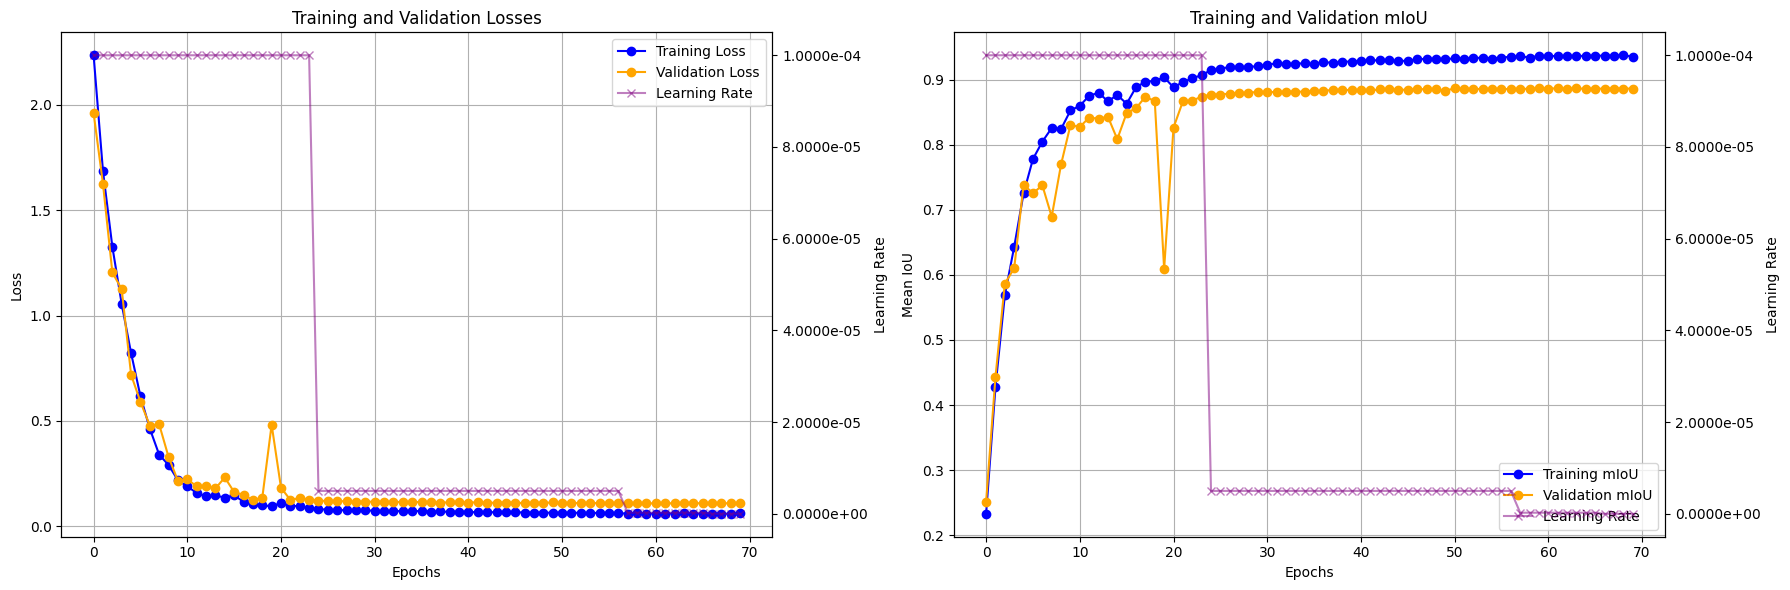

In [ ]:
"""
CHANGE THESE PARAMS ACCORDINGLY
- bs
- epochs
"""

BS = 16
EPOCHS = 500

# Intialize Model and experiment name
# device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet_Attention_Transformer_Multiscale(n_channels=3, n_classes=9, bilinear=True)
exp_name = f'{model._get_name()}_{BS}bs_gaussian'

# Move model to GPU
model = model.to(device)
# model = nn.DataParallel(model)

# Define loss function and optimizer
criterion = weighted_loss()
# criterion = torch.nn.CrossEntropyLoss(weight=weight_tensors.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


# summary(model, (3, 224, 224))

train_losses, train_mious, val_losses, val_mious, lr_rates, mean_iou_per_class = train_model(model, class_names,
                                                                                            train_dataset,
                                                                                            val_dataset,
                                                                                            criterion,
                                                                                            optimizer,
                                                                                            num_epochs=EPOCHS,
                                                                                            device=device,
                                                                                            bs=BS,
                                                                                            patience=10,
                                                                                            save_path=f'models/{exp_name}.pth')

# Plot train validation loss and mIoU curves
plot_learning_curves(train_losses, val_losses, train_mious, val_mious, lr_rates, save_path=f'lc_plots/{exp_name}.png')

---

# Load model to perform inference on val_dataset

In [14]:
model.load_state_dict(torch.load('/kaggle/working/models/UNet_Attention_Transformer_Multiscale_16bs_gaussian.pth'))
print (model)

UNet_Attention_Transformer_Multiscale(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): B

/tmp/ipykernel_5979/3595330512.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/working/models/UNet_Attention_Transformer_Multis

In [15]:
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

# Evaluation on test set
model.eval()
test_loss = 0
iou_list = []
with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)
        test_loss += loss.item()

        # Compute predictions
        _, preds = torch.max(outputs, 1)
        ious = compute_iou(preds, masks, num_classes=9)
        iou_list.append(ious)

avg_test_loss = test_loss / len(val_loader)
iou_list = np.array(iou_list)
mean_iou_per_class = np.nanmean(iou_list, axis=0)
mIoU = np.nanmean(mean_iou_per_class)

print(f"Val Loss: {avg_test_loss:.4f}, Val mIoU: {mIoU:.4f}")

# Display IoU for each class
for idx, iou in enumerate(mean_iou_per_class):
    print(f"Class {idx} ({class_names[idx]}): IoU = {iou:.4f}")


Val Loss: 0.1090, Val mIoU: 0.8867
Class 0 (background): IoU = 0.9944
Class 1 (spleen): IoU = 0.9385
Class 2 (right kidney): IoU = 0.9245
Class 3 (left kidney): IoU = 0.9205
Class 4 (gallbladder): IoU = 0.6986
Class 5 (pancreas): IoU = 0.9472
Class 6 (liver): IoU = 0.9112
Class 7 (stomach): IoU = 0.8863
Class 8 (aorta): IoU = 0.7594
